1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [73]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
from sklearn.datasets import load_diabetes

In [74]:
X, y = load_diabetes(return_X_y=True)

In [75]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [76]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [77]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [78]:
def bias(y, z):
    return (y - z)

In [79]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [80]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [81]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [82]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1021.0705558366064
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4313.626541628376


In [83]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [84]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

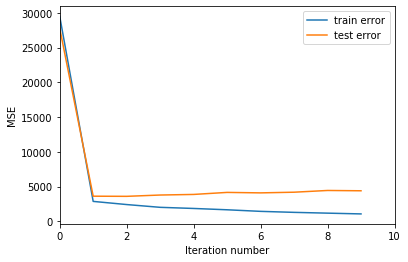

In [85]:
get_error_plot(n_trees, train_errors, test_errors)

In [86]:
eta = 0.1

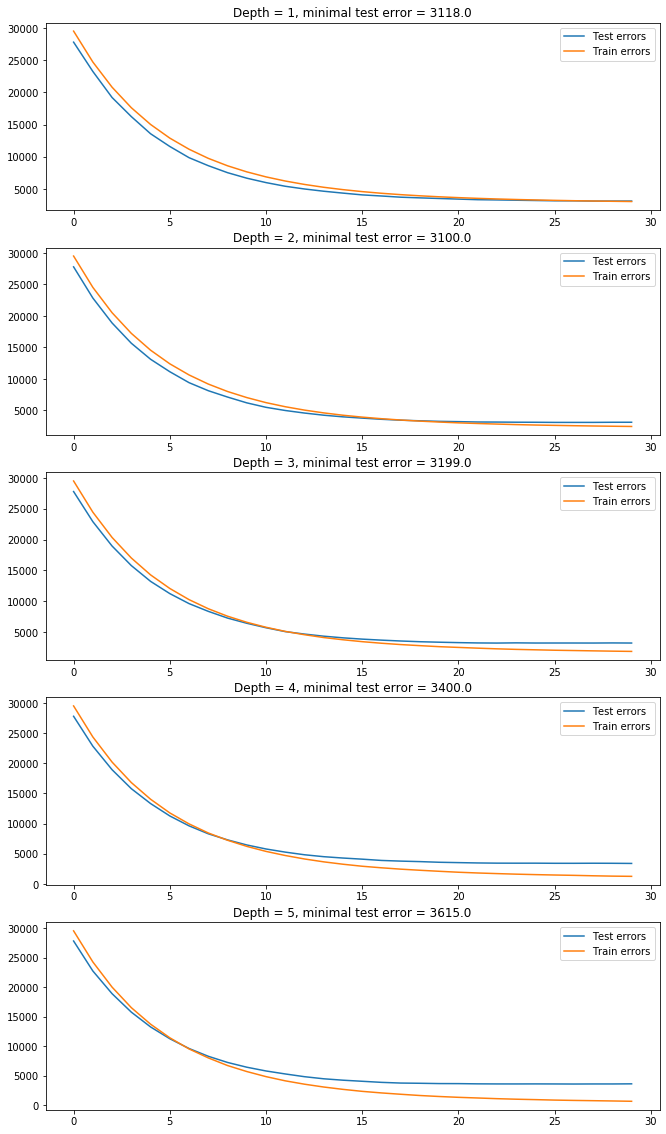

In [87]:
depth_range = range(1, 6) 
n_trees = 30
coefs = [1] * n_trees

fig, ax = plt.subplots(ncols=1,nrows=len(depth_range))
fig.set_size_inches(11, 20)
ax = ax.flatten()

for i in range(len(depth_range)):
    depth = depth_range[i]
    
    trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta)

    ax[i].plot(list(range(n_trees)), test_errors, label='Test errors')
    ax[i].plot(list(range(n_trees)), train_errors, label='Train errors')
    ax[i].legend(loc='upper right')
    ax[i].set_title('Depth = '+ str(depth)  + ', minimal test error = ' + str(round(min(test_errors),0)))

**Минимальная ошибка достигается при максимальной глубине = 2, а число деревьев более 20 является избыточным, так как ошибка более не уменьшается.**

2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [88]:
import random

In [89]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(len_sample * 0.5)
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [90]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    
    
    for i in range(n_trees):
        subsample = get_subsample(len(X_train))
        X_train_s = X_train[subsample]
        y_train_s = y_train[subsample]
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_s, y_train_s)
            
            train_errors.append(mean_squared_error(y_train_s, gb_predict(X_train_s, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_s, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_s, bias(y_train_s, target))
            
            train_errors.append(mean_squared_error(y_train_s, gb_predict(X_train_s, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [91]:
n_trees = 30

coefs = [1] * n_trees

max_depth = 2

eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_s, train_errors_s, test_errors_s = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [93]:
def get_error_plot_s(n_trees, train_err, test_err, train_err_s, test_err_s):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    
    plt.plot(list(range(n_trees)), train_err_s, label='train error with 50% subsample')
    plt.plot(list(range(n_trees)), test_err_s, label='test error with 50% subsample')
    
    plt.legend(loc='upper right')
    plt.show()

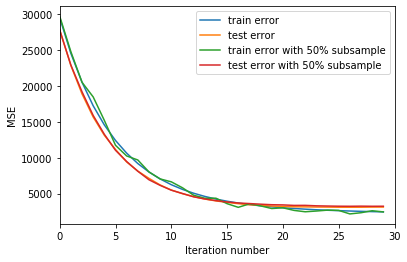

In [94]:
get_error_plot_s(n_trees, train_errors, test_errors, train_errors_s, test_errors_s)

**Различия между простым аглоритмом и стохастическим алгоритмом с 50% невелика**